In [1]:
import os
import pandas as pd
import datetime
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import CuDNNGRU
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Lambda
from keras.layers import Dropout
from keras.layers import SimpleRNN
from keras.utils import generic_utils
from keras.utils import Sequence
from keras import regularizers
from keras import optimizers
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import numpy as np
import scipy 
import math
import h5py
import time
import copy
import sys
import feather
from sklearn.metrics import mean_absolute_error
from numpy.random import seed
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)
np.set_printoptions(threshold=sys.maxsize)

Using TensorFlow backend.


In [2]:
import keras
print(os.getcwd())
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

/home/whsu014/dev/mlrig/Experiments


In [3]:
view_1hot_df = feather.read_dataframe("/home/whsu014/data/view_1hot_nona_len29_float_age_impute_and_True_HG_100096inds.feather")
print(view_1hot_df.columns)
print(view_1hot_df.shape)

print(view_1hot_df['CVD_ISOSORBRIDE_DINITRATE'].unique())
view_1hot_df = view_1hot_df.drop(['CVD_ISOSORBRIDE_DINITRATE'], axis=1)
print(view_1hot_df.shape)

Index(['VSIMPLE_INDEX_MASTER', 'QUARTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1',
       'ETHN_2', 'ETHN_3', 'ETHN_4', 'ETHN_5',
       ...
       'PT_DIABETES_YR', 'PT_ATRIAL_FIBRILLATION', 'PT_IMP_FATAL_CVD',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL',
       'TRUE_HBA1C', 'TRUE_EGFR'],
      dtype='object', length=191)
(2902784, 191)
[0.]
(2902784, 190)


In [4]:
view_1hot_df.describe()

,VSIMPLE_INDEX_MASTER,QUARTER,AGE,SEX,NZDEP,ETHN_1,ETHN_2,ETHN_3,ETHN_4,ETHN_5,TEST,HDL,LDL,TRI,TCL,TCHDL,TESTED,DIED,LL_SIMVASTATIN,LL_BEZAFIBRATE,LL_ATORVASTATIN,LL_EZETIMIBE,LL_NICOTINIC_ACID,LL_ACIPIMOX,LL_CHOLESTYRAMINE,LL_COLESTIPOL_HYDROCHLORIDE,LL_PRAVASTATIN,LL_EZETIMIBE_WITH_SIMVASTATIN,LL_GEMFIBROZIL,LL_PDC,CVD_FELODIPINE,CVD_QUINAPRIL,CVD_METOPROLOL_SUCCINATE,CVD_CILAZAPRIL,CVD_ATENOLOL,CVD_BENDROFLUMETHIAZIDE,CVD_WARFARIN_SODIUM,CVD_FUROSEMIDE,CVD_CELIPROLOL,CVD_DILTIAZEM_HYDROCHLORIDE,CVD_ASPIRIN,CVD_NIFEDIPINE,CVD_CAPTOPRIL,CVD_DIPYRIDAMOLE,CVD_CANDESARTAN_CILEXETIL,CVD_INDAPAMIDE,CVD_ENALAPRIL_MALEATE,CVD_SOTALOL,CVD_GLYCERYL_TRINITRATE,CVD_ISOSORBIDE_MONONITRATE,CVD_PINDOLOL,CVD_CARVEDILOL,CVD_METHYLDOPA,CVD_LOSARTAN_POTASSIUM,CVD_VERAPAMIL_HYDROCHLORIDE,CVD_AMILORIDE_HYDROCHLORIDE,CVD_CLONIDINE_HYDROCHLORIDE,CVD_CLONIDINE,CVD_NADOLOL,CVD_PROPRANOLOL,CVD_AMLODIPINE,CVD_LABETALOL,CVD_LISINOPRIL,CVD_TRIAMTERENE,CVD_TIMOLOL,CVD_METOPROLOL_TARTRATE,CVD_ACEBUTOLOL,CVD_PERHEXILINE_MALEATE,CVD_CHLORTALIDONE,CVD_BUMETANIDE,CVD_PERINDOPRIL,CVD_TRANDOLAPRIL,CVD_CLOPIDOGREL,CVD_ISRADIPINE,CVD_RIVAROXABAN,CVD_DABIGATRAN,CVD_BISOPROLOL_FUMARATE,CVD_PRASUGREL,CVD_NICORANDIL,CVD_METOLAZONE,CVD_TICAGRELOR,CVD_HYDRALAZINE_HYDROCHLORIDE,CVD_HYDROCHLOROTHIAZIDE,OTHER_TENOXICAM,OTHER_PANTOPRAZOLE,OTHER_OMEPRAZOLE,OTHER_NAPROXEN_SODIUM,OTHER_DICLOFENAC_SODIUM,OTHER_METFORMIN_HYDROCHLORIDE,OTHER_SULINDAC,OTHER_GLICLAZIDE,OTHER_GLIPIZIDE,OTHER_INSULIN_ISOPHANE,OTHER_INSULIN_NEUTRAL,OTHER_KETOPROFEN,OTHER_IBUPROFEN,OTHER_INSULIN_ASPART,OTHER_PREDNISONE,OTHER_INDOMETHACIN,OTHER_NAPROXEN,OTHER_GLIBENCLAMIDE,OTHER_RANITIDINE,OTHER_PIROXICAM,OTHER_INSULIN_LISPRO,OTHER_TIAPROFENIC_ACID,OTHER_PIOGLITAZONE,OTHER_DEXAMETHASONE,OTHER_INSULIN_ZINC_SUSPENSION,OTHER_HYDROCORTISONE,OTHER_PREDNISOLONE,OTHER_TOLBUTAMIDE,OTHER_MEFENAMIC_ACID,OTHER_LANSOPRAZOLE,OTHER_METHYLPREDNISOLONE,OTHER_INSULIN_GLARGINE,OTHER_INSULIND_GLULISINE,OTHER_AMOXYCILLIN,OTHER_CLARITHROMYCIN,OTHER_INSULIN_LISPRO_PROTAMINE,OTHER_INSULIN_ASPART_PROTAMINE,OTHER_VILDAGLIPTIN,NUMBER_OF_DAYS,ACUTE_ADM,hx_broad_cvd,hx_athero_cvd,hx_chd_diags,hx_acs,hx_mi,hx_unst_angina,hx_angina,hx_other_chd,hx_chd_procs,hx_pci,hx_cabg,hx_other_chd_procs,hx_pvd_diags,hx_pvd_procs,hx_haemorrhagic_stroke,hx_cevd,hx_ischaemic_stroke,hx_tia,hx_other_cevd,hx_heart_failure,hx_atrial_fibrillation,mortality_broad_cvd_with_other,mortality_other_related_cvd_deaths,out_broad_cvd,out_athero_cvd,out_chd,out_mi,out_acs,out_unst_angina,out_angina,out_other_chd,out_pvd_diags,out_pvd_procs,out_pci_cabg,out_haemorrhagic_stroke,out_cevd,out_ischaemic_stroke,out_tia,out_other_cevd,out_heart_failure,out_atrial_fibrillation,HBA1C,TEST_HBA1C,TESTED_HBA1C,EGFR,TEST_EGFR,TESTED_EGFR,PT_SBP,PT_SBP2,PT_DBP,PT_DBP2,PT_SMOKING,PT_EN_TCHDL,PT_DIABETES,PT_FAMILY_HISTORY,PT_GEN_LIPID,PT_RENAL,PT_DIABETES_YR,PT_ATRIAL_FIBRILLATION,PT_IMP_FATAL_CVD
count,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.

In [5]:
print("Number of inds:", len(view_1hot_df['VSIMPLE_INDEX_MASTER'].unique()))
# set length to 28
print(view_1hot_df.shape[0]/29)
view_1hot_df = copy.deepcopy(view_1hot_df[view_1hot_df['QUARTER']!=0])
print(view_1hot_df.shape[0]/28)
# Take 90000 inds for train and validation set
# remove true values
# remove QUARTER
view_1hot_df = view_1hot_df.drop(['QUARTER'], axis=1)
train_v = copy.deepcopy(view_1hot_df.iloc[:(28*90000), :-7].values)
print(train_v.shape)
print(train_v.shape[0]/28)

Number of inds: 100096
100096.0
100096.0
(2520000, 182)
90000.0


In [6]:
# standardise data
# z = (X - u)/s
# u is the mean of the training samples
# s is the standard devidation of the training samples
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_v) 

In [7]:
print('LL_PDC:', view_1hot_df.columns.get_loc('LL_PDC'))
#print('Unique LL_PDC:', np.unique(train_v[:, 28]))

LL_PDC: 28


In [8]:
# make x_train and y_train
num_of_inds = train_v.shape[0]//28
print("Number of inds:", num_of_inds)
num_of_features = train_v.shape[1]
print("Number of features:", num_of_features)

x_train = np.empty((num_of_inds, 8, num_of_features))
# creating 2 binary vectors for softmax 
# non-adherent and adherent
y_train = np.empty((num_of_inds, 2))

for i in range(num_of_inds):
    ind_v = train_v[(i*28):((i+1)*28), :]
    if sum(ind_v[8:28, 28])/20 >= 80:
        y_train[i, 0] = 0.0
        y_train[i, 1] = 1.0
    else:
        y_train[i, 0] = 1.0
        y_train[i, 1] = 0.0
    scaled_ind_v = scaled_train[(i*28):((i+1)*28), :]
    x_train[i] = scaled_ind_v[:8, :]

print(x_train.shape)
print(y_train.shape)

Number of inds: 90000
Number of features: 182
(90000, 8, 182)
(90000, 2)


In [9]:
num_per_fold = x_train.shape[0]//10
print(num_per_fold)

9000


In [14]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

num_per_fold = x_train.shape[0]//10
print(num_per_fold)

units_list = [2, 4, 8, 16, 32]
batch_size_list = [128, 256, 512, 1024, 2048]

start_time = time.time()

exp_record = []

for units in units_list:
    for batch_s in batch_size_list:
        for f in range(5):#10
            #start = f*num_per_fold
            end = (f+1)*num_per_fold
            train1_x = x_train[:end, ]
            train2_x = x_train[end:, ]
            train_x_lstm = np.append(train2_x, train1_x, axis=0) 
            train1_y = y_train[:end, ]
            train2_y = y_train[end:, ]
            train_y_lstm = np.append(train2_y, train1_y, axis=0)

            start_time_inner = time.time()
            with tf.Session(config = tf.ConfigProto(log_device_placement = True)):
                model = Sequential()
                model.add(CuDNNLSTM(units,
                                    kernel_regularizer=regularizers.l2(0.01),
                                    return_sequences=True, 
                                    input_shape=(8, 182))) #20 , 27
                model.add(CuDNNLSTM(units, 
                                    kernel_regularizer=regularizers.l2(0.01)))
                model.add(Dense(2, activation='softmax'))
                model.compile(loss='categorical_crossentropy', 
                              optimizer='adam', metrics=['accuracy'])
                val_weight = "val_weights" + str(f+1) + ".hdf5"
                val_checkpointer = ModelCheckpoint(filepath=val_weight,
                                            monitor='val_loss', verbose=1,
                                            save_best_only=True)
                history = model.fit(train_x_lstm, train_y_lstm, batch_size=batch_s, 
                                    epochs=100, validation_split=0.1, 
                                    callbacks=[val_checkpointer], 
                                    verbose=2, 
                                    shuffle=False) 
                print("#################################")
                print("Number of units:", units)
                print("Batch size:", batch_s)
                print("Fold:", f)
                print("best val loss:", min(history.history['val_loss']))
                exp_record.append([units, batch_s, f, min(history.history['val_loss'])])
                print("#################################")
                if(f==4):
                    print(exp_record)
                pyplot.plot(history.history['loss'], label='train')
                pyplot.plot(history.history['val_loss'], label='validation')
                pyplot.legend()
                pyplot.show()
            end_time = time.time()
            print("Time to train LSTM: ", time.time() - start_time_inner)
print("Entire process took: ", time.time() - start_time)

print("Experiment record:")
print(exp_record)

Experiment record:
[[2, 128, 0, 0.5292124069531758], [2, 128, 1, 0.5370533213615417], [2, 128, 2, 0.5420131676461961], [2, 128, 3, 0.551739940378401], [2, 128, 4, 0.5386780424118042], [2, 256, 0, 0.5290633578830295], [2, 256, 1, 0.5375123489167956], [2, 256, 2, 0.5434863215022617], [2, 256, 3, 0.5459987904230753], [2, 256, 4, 0.5315338863266839], [2, 512, 0, 0.5313693800502354], [2, 512, 1, 0.5361782812542385], [2, 512, 2, 0.5435176512930129], [2, 512, 3, 0.5456835323439704], [2, 512, 4, 0.5336274352603488], [2, 1024, 0, 0.532363291475508], [2, 1024, 1, 0.5350317666795519], [2, 1024, 2, 0.5406219792366028], [2, 1024, 3, 0.5501790897581312], [2, 1024, 4, 0.5303303052054511], [2, 2048, 0, 0.5318787086804708], [2, 2048, 1, 0.5351276316112942], [2, 2048, 2, 0.5465200509495205], [2, 2048, 3, 0.5513382068739997], [2, 2048, 4, 0.5334830463197496], [4, 128, 0, 0.5244396574762132], [4, 128, 1, 0.5339460620880127], [4, 128, 2, 0.5366398413976033], [4, 128, 3, 0.54550331597858], [4, 128, 4, 0.530

In [15]:
complete_v = np.array(exp_record)
print(complete_v.shape)

val_loss_list = []
for i in range(14):
    h_params = complete_v[(i*5):((i+1)*5), :]
    print("###############################")
    print("Units:", h_params[0, 0])
    print("Batch size:", h_params[0, 1])
    #print("Val loss (mean):", np.mean(h_params[:, 3]))
    #print("Val loss (std):", np.std(h_params[:, 3]))
    print("Val loss (mean):", 
          np.round(np.mean(h_params[:, 3]), decimals=5))
    print("Val loss (std):", 
          np.round(np.std(h_params[:, 3]), decimals=5))
    print("###############################")
    val_loss_list.append(np.mean(h_params[:, 3]))
print(min(val_loss_list))

(125, 4)
###############################
Units: 2.0
Batch size: 128.0
Val loss (mean): 0.53974
Val loss (std): 0.00733
###############################
###############################
Units: 2.0
Batch size: 256.0
Val loss (mean): 0.53752
Val loss (std): 0.00655
###############################
###############################
Units: 2.0
Batch size: 512.0
Val loss (mean): 0.53808
Val loss (std): 0.00558
###############################
###############################
Units: 2.0
Batch size: 1024.0
Val loss (mean): 0.53771
Val loss (std): 0.00713
###############################
###############################
Units: 2.0
Batch size: 2048.0
Val loss (mean): 0.53967
Val loss (std): 0.00778
###############################
###############################
Units: 4.0
Batch size: 128.0
Val loss (mean): 0.53424
Val loss (std): 0.00695
###############################
###############################
Units: 4.0
Batch size: 256.0
Val loss (mean): 0.53211
Val loss (std): 0.00668
###########################

In [16]:
units = 4
model = Sequential()
model.add(CuDNNLSTM(units, 
                    kernel_regularizer=regularizers.l2(0.01),
                    return_sequences=True, 
                    input_shape=(8, 182))) 
model.add(CuDNNLSTM(units,
                    kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(2, activation='softmax'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 8, 4)              3008      
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 4)                 160       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 10        
Total params: 3,178
Trainable params: 3,178
Non-trainable params: 0
_________________________________________________________________


In [17]:
###########################
# generate random numbers
# for layer 1 and 2 
# L2 search
###########################
from numpy.random import seed
seed(6) # seed 6 for LSTM seed 8 for SimpleRNN
# L2 for layer 1 between 0.005 and 0.015
L2_1_list = []
for i in range(25):
    L2_1_list.append(np.random.uniform(0.005, 0.015))
# L2 for layer 2 between 1e-4 and 1e-8
L2_2_list = []
for i in range(25):
    r = -4*np.random.rand()
    s = 0.0001*(10**r)
    L2_2_list.append(s)
print("Min L2 layer 1:\t", min(L2_1_list))
print("Max L2 layer 1:\t", max(L2_1_list))
print("Min L2 layer 2:\t", min(L2_2_list))
print("Max L2 layer 2:\t", max(L2_2_list))
print("Layer 1 L2:\t", L2_1_list)
print("Layer 2 L2:\t", L2_2_list)

Min L2 layer 1:	 0.005416966257252499
Max L2 layer 1:	 0.014902242713734162
Min L2 layer 2:	 1.0548003040594255e-08
Max L2 layer 2:	 4.679137276988068e-05
Layer 1 L2:	 [0.013928601514360015, 0.008319798053011772, 0.013212291230578318, 0.005416966257252499, 0.006076566799359679, 0.010950520642062402, 0.010298173621928215, 0.009188074285566544, 0.008354078492733293, 0.0112251943219609, 0.00938141426108874, 0.012358821063486902, 0.010180364119992687, 0.01078858600226157, 0.011453550958955937, 0.014902242713734162, 0.013198581969218411, 0.009132009348161808, 0.013762676552066273, 0.013237594325705211, 0.005544745078223546, 0.012186372365641941, 0.013021705624244751, 0.012364066438114388, 0.012091317507811672]
Layer 2 L2:	 [6.858870178141104e-07, 3.167402845030375e-05, 1.4771031289939846e-08, 2.437669396551291e-06, 1.3557991543934365e-05, 1.351750734365101e-07, 1.0548003040594255e-08, 9.496067162936562e-06, 2.0642499000654993e-07, 4.0176892910405197e-07, 1.3510499874895139e-07, 1.7807455241

In [18]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

num_per_fold = x_train.shape[0]//10
print(num_per_fold)

units = 4
batch_s = 512

start_time = time.time()

exp_record = []

for i in range(2):
    L2_1 = L2_1_list[i]
    L2_2 = L2_2_list[i]
    for f in range(5):#10
        #start = f*num_per_fold
        end = (f+1)*num_per_fold
        train1_x = x_train[:end, ]
        train2_x = x_train[end:, ]
        train_x_lstm = np.append(train2_x, train1_x, axis=0) 
        train1_y = y_train[:end, ]
        train2_y = y_train[end:, ]
        train_y_lstm = np.append(train2_y, train1_y, axis=0)

        start_time_inner = time.time()
        with tf.Session(config = tf.ConfigProto(log_device_placement = True)):
            model = Sequential()
            model.add(CuDNNLSTM(units, 
                                kernel_regularizer=regularizers.l2(L2_1),
                                return_sequences=True, 
                                input_shape=(8, 182))) 
            model.add(CuDNNLSTM(units, 
                                kernel_regularizer=regularizers.l2(L2_2)))
            model.add(Dense(2, activation='softmax'))
            model.compile(loss='categorical_crossentropy', 
                          optimizer='adam', metrics=['accuracy'])
            val_weight = "val_weights" + str(f+1) + ".hdf5"
            val_checkpointer = ModelCheckpoint(filepath=val_weight,
                                               monitor='val_loss', verbose=1,
                                               save_best_only=True)
            history = model.fit(train_x_lstm, train_y_lstm, batch_size=batch_s, 
                                epochs=100, validation_split=0.1, 
                                callbacks=[val_checkpointer], 
                                verbose=2, 
                                shuffle=False) 
            print("#################################")
            print("Number of units:", units)
            print("Batch size:", batch_s)
            print("Fold:", f)
            print("L2_1:", L2_1)
            print("L2_2:", L2_2)
            print("best val loss:", min(history.history['val_loss']))
            exp_record.append([units, batch_s, L2_1, L2_2, f, min(history.history['val_loss'])])
            print("#################################")
            if(f==4):
                print(exp_record)
            pyplot.plot(history.history['loss'], label='train')
            pyplot.plot(history.history['val_loss'], label='validation')
            pyplot.legend()
            pyplot.show()
    end_time = time.time()
    print("Time to train LSTM: ", time.time() - start_time_inner)
print("Entire process took: ", time.time() - start_time)

print("Experiment record:")
print(exp_record)

Experiment record:
[[4, 512, 0.013928601514360015, 6.858870178141104e-07, 0, 0.5219083029958936], [4, 512, 0.013928601514360015, 6.858870178141104e-07, 1, 0.5291545008553399], [4, 512, 0.013928601514360015, 6.858870178141104e-07, 2, 0.5320769005881415], [4, 512, 0.013928601514360015, 6.858870178141104e-07, 3, 0.5354192076259189], [4, 512, 0.013928601514360015, 6.858870178141104e-07, 4, 0.5241844132741292], [4, 512, 0.008319798053011772, 3.167402845030375e-05, 0, 0.5219111855294969], [4, 512, 0.008319798053011772, 3.167402845030375e-05, 1, 0.5296227021217346], [4, 512, 0.008319798053011772, 3.167402845030375e-05, 2, 0.5308556541336907], [4, 512, 0.008319798053011772, 3.167402845030375e-05, 3, 0.5363604740036858], [4, 512, 0.008319798053011772, 3.167402845030375e-05, 4, 0.523487463288837], [4, 512, 0.013212291230578318, 1.4771031289939846e-08, 0, 0.5208550225363837], [4, 512, 0.013212291230578318, 1.4771031289939846e-08, 1, 0.5278483155568441], [4, 512, 0.013212291230578318, 1.4771031289

In [19]:
complete_v = np.array(exp_record)
print(complete_v.shape)

val_loss_list = []
for i in range(25):
    h_params = complete_v[(i*5):((i+1)*5), :]
    print("###############################")
    print("Units:", h_params[0, 0])
    print("Batch size:", h_params[0, 1])
    print("L2 1:", h_params[0, 2])
    print("h2 2:", h_params[0, 3])
    #print("Val loss (mean):", np.mean(h_params[:, 5]))
    #print("Val loss (std):", np.std(h_params[:, 5]))
    print("Val loss (mean):", 
          np.round(np.mean(h_params[:, 5]), decimals=5))
    print("Val loss (std):", 
          np.round(np.std(h_params[:, 5]), decimals=5))
    print("###############################")
    val_loss_list.append(np.mean(h_params[:, 5]))
print(min(val_loss_list))

(125, 6)
###############################
Units: 4.0
Batch size: 512.0
L2 1: 0.013928601514360015
h2 2: 6.858870178141104e-07
Val loss (mean): 0.52855
Val loss (std): 0.00496
###############################
###############################
Units: 4.0
Batch size: 512.0
L2 1: 0.008319798053011772
h2 2: 3.167402845030375e-05
Val loss (mean): 0.52845
Val loss (std): 0.00524
###############################
###############################
Units: 4.0
Batch size: 512.0
L2 1: 0.013212291230578318
h2 2: 1.4771031289939846e-08
Val loss (mean): 0.52726
Val loss (std): 0.00473
###############################
###############################
Units: 4.0
Batch size: 512.0
L2 1: 0.005416966257252499
h2 2: 2.437669396551291e-06
Val loss (mean): 0.52792
Val loss (std): 0.00519
###############################
###############################
Units: 4.0
Batch size: 512.0
L2 1: 0.006076566799359679
h2 2: 1.3557991543934365e-05
Val loss (mean): 0.52822
Val loss (std): 0.00521
###############################
####

## Surface plot of h_params (Units and batch size)

In [5]:
x = np.array([2, 4, 8, 16, 32])
y = np.array([128, 256, 512, 1024, 2048])
complete_list = [[0.53974,0.53424,0.53567,0.53887,0.54219],
                 [0.53752,0.53211,0.53497,0.53798,0.54063],
                 [0.53808,0.5302,0.53379,0.53705,0.54061],
                 [0.53771,0.53031,0.53267,0.53635,0.53803],
                 [0.53967,0.53073,0.53402,0.53762,0.53743]]
X,Y = np.meshgrid(x, y)
print(X)
print(Y)
print(np.round(complete_list, decimals=5))

[[ 2  4  8 16 32]
 [ 2  4  8 16 32]
 [ 2  4  8 16 32]
 [ 2  4  8 16 32]
 [ 2  4  8 16 32]]
[[ 128  128  128  128  128]
 [ 256  256  256  256  256]
 [ 512  512  512  512  512]
 [1024 1024 1024 1024 1024]
 [2048 2048 2048 2048 2048]]
[[0.53974 0.53424 0.53567 0.53887 0.54219]
 [0.53752 0.53211 0.53497 0.53798 0.54063]
 [0.53808 0.5302  0.53379 0.53705 0.54061]
 [0.53771 0.53031 0.53267 0.53635 0.53803]
 [0.53967 0.53073 0.53402 0.53762 0.53743]]


(5, 5)
(5, 5)
(5, 5)


<IPython.core.display.Javascript object>


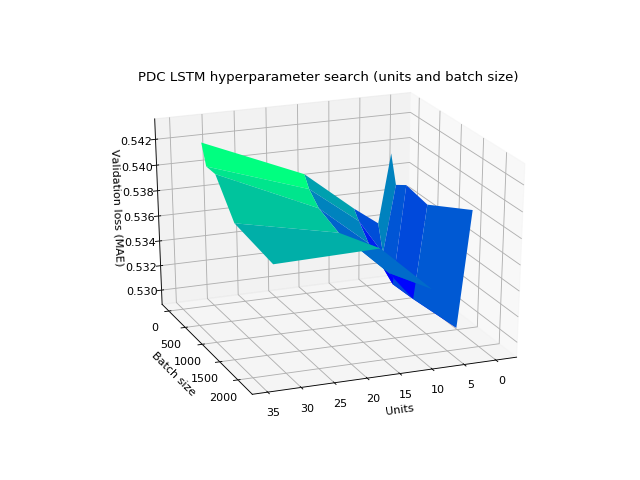

In [6]:
%matplotlib notebook
from mpl_toolkits.mplot3d import axes3d    
from mpl_toolkits import mplot3d

X,Y = np.meshgrid(x, y)
z = np.array(complete_list)
print(X.shape)
print(Y.shape)
print(z.shape)
fig = pyplot.figure(figsize=(8, 6))
ax = pyplot.axes(projection='3d')

ax.set_xlabel('Units')
ax.set_ylabel('Batch size')
ax.set_zlabel('Validation loss (MAE)')

ax.plot_surface(X, Y, z, rstride=1, cstride=1,
                cmap='winter', edgecolor='none')
ax.set_title('PDC LSTM hyperparameter search (units and batch size)')
pyplot.show()

## Surface plot of h_params (Layer 1 and 2 L2 params)

(125, 6)
(25, 3)


<IPython.core.display.Javascript object>


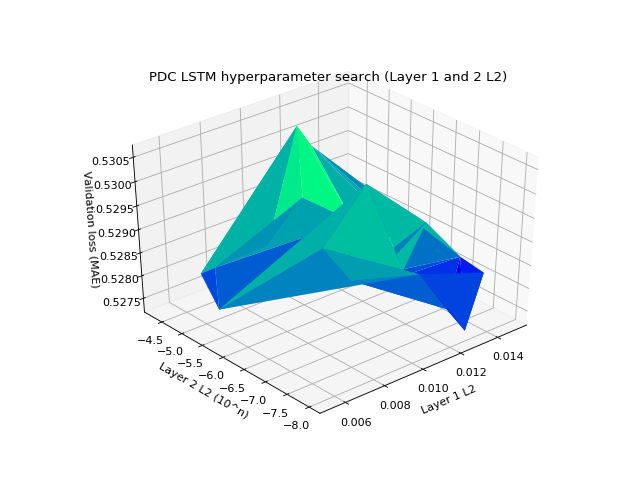

Text(0.5, 0.92, 'PDC LSTM hyperparameter search (Layer 1 and 2 L2)')

In [13]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D   
from mpl_toolkits import mplot3d

# CuDNNLSTM
exp_record = [[4, 512, 0.013928601514360015, 6.858870178141104e-07, 0, 0.5219083029958936], [4, 512, 0.013928601514360015, 6.858870178141104e-07, 1, 0.5291545008553399], [4, 512, 0.013928601514360015, 6.858870178141104e-07, 2, 0.5320769005881415], [4, 512, 0.013928601514360015, 6.858870178141104e-07, 3, 0.5354192076259189], [4, 512, 0.013928601514360015, 6.858870178141104e-07, 4, 0.5241844132741292], [4, 512, 0.008319798053011772, 3.167402845030375e-05, 0, 0.5219111855294969], [4, 512, 0.008319798053011772, 3.167402845030375e-05, 1, 0.5296227021217346], [4, 512, 0.008319798053011772, 3.167402845030375e-05, 2, 0.5308556541336907], [4, 512, 0.008319798053011772, 3.167402845030375e-05, 3, 0.5363604740036858], [4, 512, 0.008319798053011772, 3.167402845030375e-05, 4, 0.523487463288837], [4, 512, 0.013212291230578318, 1.4771031289939846e-08, 0, 0.5208550225363837], [4, 512, 0.013212291230578318, 1.4771031289939846e-08, 1, 0.5278483155568441], [4, 512, 0.013212291230578318, 1.4771031289939846e-08, 2, 0.5310275309880574], [4, 512, 0.013212291230578318, 1.4771031289939846e-08, 3, 0.5334838685459561], [4, 512, 0.013212291230578318, 1.4771031289939846e-08, 4, 0.5230909896161822], [4, 512, 0.005416966257252499, 2.437669396551291e-06, 0, 0.5241206760936313], [4, 512, 0.005416966257252499, 2.437669396551291e-06, 1, 0.5267475415335762], [4, 512, 0.005416966257252499, 2.437669396551291e-06, 2, 0.5297865720325046], [4, 512, 0.005416966257252499, 2.437669396551291e-06, 3, 0.5369135946697658], [4, 512, 0.005416966257252499, 2.437669396551291e-06, 4, 0.5220503807597691], [4, 512, 0.006076566799359679, 1.3557991543934365e-05, 0, 0.522252324157291], [4, 512, 0.006076566799359679, 1.3557991543934365e-05, 1, 0.527735209412045], [4, 512, 0.006076566799359679, 1.3557991543934365e-05, 2, 0.5310602212482028], [4, 512, 0.006076566799359679, 1.3557991543934365e-05, 3, 0.5365577008459304], [4, 512, 0.006076566799359679, 1.3557991543934365e-05, 4, 0.5235095547835033], [4, 512, 0.010950520642062402, 1.351750734365101e-07, 0, 0.5216332800653246], [4, 512, 0.010950520642062402, 1.351750734365101e-07, 1, 0.5288405764897665], [4, 512, 0.010950520642062402, 1.351750734365101e-07, 2, 0.5306163459883796], [4, 512, 0.010950520642062402, 1.351750734365101e-07, 3, 0.5354003344641791], [4, 512, 0.010950520642062402, 1.351750734365101e-07, 4, 0.5258623287942674], [4, 512, 0.010298173621928215, 1.0548003040594255e-08, 0, 0.5239445060624016], [4, 512, 0.010298173621928215, 1.0548003040594255e-08, 1, 0.529404367658827], [4, 512, 0.010298173621928215, 1.0548003040594255e-08, 2, 0.5332088046603732], [4, 512, 0.010298173621928215, 1.0548003040594255e-08, 3, 0.5337552976608276], [4, 512, 0.010298173621928215, 1.0548003040594255e-08, 4, 0.5249464598761665], [4, 512, 0.009188074285566544, 9.496067162936562e-06, 0, 0.5226418818897671], [4, 512, 0.009188074285566544, 9.496067162936562e-06, 1, 0.5274267740779452], [4, 512, 0.009188074285566544, 9.496067162936562e-06, 2, 0.5325496140056186], [4, 512, 0.009188074285566544, 9.496067162936562e-06, 3, 0.5358237741788229], [4, 512, 0.009188074285566544, 9.496067162936562e-06, 4, 0.5236093607743582], [4, 512, 0.008354078492733293, 2.0642499000654993e-07, 0, 0.5251338052219815], [4, 512, 0.008354078492733293, 2.0642499000654993e-07, 1, 0.5263743906021118], [4, 512, 0.008354078492733293, 2.0642499000654993e-07, 2, 0.5317411077287462], [4, 512, 0.008354078492733293, 2.0642499000654993e-07, 3, 0.5394629018571642], [4, 512, 0.008354078492733293, 2.0642499000654993e-07, 4, 0.5236712615754869], [4, 512, 0.0112251943219609, 4.0176892910405197e-07, 0, 0.5239868585268657], [4, 512, 0.0112251943219609, 4.0176892910405197e-07, 1, 0.5291255274878608], [4, 512, 0.0112251943219609, 4.0176892910405197e-07, 2, 0.5328930331865946], [4, 512, 0.0112251943219609, 4.0176892910405197e-07, 3, 0.5379773135185242], [4, 512, 0.0112251943219609, 4.0176892910405197e-07, 4, 0.5261794091860453], [4, 512, 0.00938141426108874, 1.3510499874895139e-07, 0, 0.5221405124664307], [4, 512, 0.00938141426108874, 1.3510499874895139e-07, 1, 0.5276882331636217], [4, 512, 0.00938141426108874, 1.3510499874895139e-07, 2, 0.5314209589958191], [4, 512, 0.00938141426108874, 1.3510499874895139e-07, 3, 0.5364207326571147], [4, 512, 0.00938141426108874, 1.3510499874895139e-07, 4, 0.5249251436392466], [4, 512, 0.012358821063486902, 1.7807455241026175e-08, 0, 0.5213540301322938], [4, 512, 0.012358821063486902, 1.7807455241026175e-08, 1, 0.5276868477397495], [4, 512, 0.012358821063486902, 1.7807455241026175e-08, 2, 0.5327388149897258], [4, 512, 0.012358821063486902, 1.7807455241026175e-08, 3, 0.5341129976908366], [4, 512, 0.012358821063486902, 1.7807455241026175e-08, 4, 0.5233455669615004], [4, 512, 0.010180364119992687, 3.915262870179551e-06, 0, 0.5230665856467352], [4, 512, 0.010180364119992687, 3.915262870179551e-06, 1, 0.5302389176156785], [4, 512, 0.010180364119992687, 3.915262870179551e-06, 2, 0.5328308895428976], [4, 512, 0.010180364119992687, 3.915262870179551e-06, 3, 0.536784428331587], [4, 512, 0.010180364119992687, 3.915262870179551e-06, 4, 0.524382329278522], [4, 512, 0.01078858600226157, 9.670826906149005e-06, 0, 0.5263913781907823], [4, 512, 0.01078858600226157, 9.670826906149005e-06, 1, 0.5304661033948262], [4, 512, 0.01078858600226157, 9.670826906149005e-06, 2, 0.5341672696007622], [4, 512, 0.01078858600226157, 9.670826906149005e-06, 3, 0.5361236222055223], [4, 512, 0.01078858600226157, 9.670826906149005e-06, 4, 0.5262327320575714], [4, 512, 0.011453550958955937, 2.455330529445889e-06, 0, 0.5229656693140665], [4, 512, 0.011453550958955937, 2.455330529445889e-06, 1, 0.5278953991466099], [4, 512, 0.011453550958955937, 2.455330529445889e-06, 2, 0.5307626608742608], [4, 512, 0.011453550958955937, 2.455330529445889e-06, 3, 0.5350760618845621], [4, 512, 0.011453550958955937, 2.455330529445889e-06, 4, 0.5209963959323035], [4, 512, 0.014902242713734162, 1.0326594680279903e-07, 0, 0.5200918401612176], [4, 512, 0.014902242713734162, 1.0326594680279903e-07, 1, 0.5281963235007392], [4, 512, 0.014902242713734162, 1.0326594680279903e-07, 2, 0.5304122877120971], [4, 512, 0.014902242713734162, 1.0326594680279903e-07, 3, 0.5378740226957534], [4, 512, 0.014902242713734162, 1.0326594680279903e-07, 4, 0.524398277229733], [4, 512, 0.013198581969218411, 1.2697485640295471e-07, 0, 0.51997626680798], [4, 512, 0.013198581969218411, 1.2697485640295471e-07, 1, 0.528851474708981], [4, 512, 0.013198581969218411, 1.2697485640295471e-07, 2, 0.5318041721449958], [4, 512, 0.013198581969218411, 1.2697485640295471e-07, 3, 0.5398203801049126], [4, 512, 0.013198581969218411, 1.2697485640295471e-07, 4, 0.5253436955610911], [4, 512, 0.009132009348161808, 2.374481639416423e-06, 0, 0.5224896117846171], [4, 512, 0.009132009348161808, 2.374481639416423e-06, 1, 0.5274189123577542], [4, 512, 0.009132009348161808, 2.374481639416423e-06, 2, 0.5325256139967177], [4, 512, 0.009132009348161808, 2.374481639416423e-06, 3, 0.5365882856580946], [4, 512, 0.009132009348161808, 2.374481639416423e-06, 4, 0.522874224503835], [4, 512, 0.013762676552066273, 1.1027589898093529e-08, 0, 0.521368215031094], [4, 512, 0.013762676552066273, 1.1027589898093529e-08, 1, 0.5276055732833015], [4, 512, 0.013762676552066273, 1.1027589898093529e-08, 2, 0.5305945823457506], [4, 512, 0.013762676552066273, 1.1027589898093529e-08, 3, 0.5381487418810527], [4, 512, 0.013762676552066273, 1.1027589898093529e-08, 4, 0.5248285235034095], [4, 512, 0.013237594325705211, 1.5776217207489262e-06, 0, 0.5226196621788872], [4, 512, 0.013237594325705211, 1.5776217207489262e-06, 1, 0.528454282283783], [4, 512, 0.013237594325705211, 1.5776217207489262e-06, 2, 0.5324096188015408], [4, 512, 0.013237594325705211, 1.5776217207489262e-06, 3, 0.5362070058716668], [4, 512, 0.013237594325705211, 1.5776217207489262e-06, 4, 0.5246192468802134], [4, 512, 0.005544745078223546, 3.1971739340977804e-06, 0, 0.5193747622172038], [4, 512, 0.005544745078223546, 3.1971739340977804e-06, 1, 0.529263970428043], [4, 512, 0.005544745078223546, 3.1971739340977804e-06, 2, 0.5360118640263876], [4, 512, 0.005544745078223546, 3.1971739340977804e-06, 3, 0.5349889656172858], [4, 512, 0.005544745078223546, 3.1971739340977804e-06, 4, 0.5241090568701426], [4, 512, 0.012186372365641941, 1.4503926000987367e-07, 0, 0.5223677926593356], [4, 512, 0.012186372365641941, 1.4503926000987367e-07, 1, 0.5270387030707465], [4, 512, 0.012186372365641941, 1.4503926000987367e-07, 2, 0.5321695501009623], [4, 512, 0.012186372365641941, 1.4503926000987367e-07, 3, 0.5360259058740404], [4, 512, 0.012186372365641941, 1.4503926000987367e-07, 4, 0.5237124879625108], [4, 512, 0.013021705624244751, 4.679137276988068e-05, 0, 0.5221770712004767], [4, 512, 0.013021705624244751, 4.679137276988068e-05, 1, 0.5297212356991238], [4, 512, 0.013021705624244751, 4.679137276988068e-05, 2, 0.5334743843608433], [4, 512, 0.013021705624244751, 4.679137276988068e-05, 3, 0.5385921231905619], [4, 512, 0.013021705624244751, 4.679137276988068e-05, 4, 0.5243183686203426], [4, 512, 0.012364066438114388, 2.549812963309615e-06, 0, 0.5218032386038038], [4, 512, 0.012364066438114388, 2.549812963309615e-06, 1, 0.5303264169163174], [4, 512, 0.012364066438114388, 2.549812963309615e-06, 2, 0.5308246295717027], [4, 512, 0.012364066438114388, 2.549812963309615e-06, 3, 0.5353060931629605], [4, 512, 0.012364066438114388, 2.549812963309615e-06, 4, 0.5252889157136281], [4, 512, 0.012091317507811672, 8.250421467428344e-08, 0, 0.5197874821556939], [4, 512, 0.012091317507811672, 8.250421467428344e-08, 1, 0.5296026106410556], [4, 512, 0.012091317507811672, 8.250421467428344e-08, 2, 0.5322375494639079], [4, 512, 0.012091317507811672, 8.250421467428344e-08, 3, 0.5369802495108711], [4, 512, 0.012091317507811672, 8.250421467428344e-08, 4, 0.5231328007645077]]
# SimpleRNN
#exp_record = [[8, 2048, 0.013734294027918162, 1.2615958279503796e-05, 0, 0.5242269070413378], [8, 2048, 0.013734294027918162, 1.2615958279503796e-05, 1, 0.525349099000295], [8, 2048, 0.013734294027918162, 1.2615958279503796e-05, 2, 0.5365885543823242], [8, 2048, 0.013734294027918162, 1.2615958279503796e-05, 3, 0.5425988081296285], [8, 2048, 0.013734294027918162, 1.2615958279503796e-05, 4, 0.5277500336964925], [8, 2048, 0.01468540662820932, 2.66354685054784e-06, 0, 0.5267950610584683], [8, 2048, 0.01468540662820932, 2.66354685054784e-06, 1, 0.5295367503696018], [8, 2048, 0.01468540662820932, 2.66354685054784e-06, 2, 0.5359356097645229], [8, 2048, 0.01468540662820932, 2.66354685054784e-06, 3, 0.5404754420916239], [8, 2048, 0.01468540662820932, 2.66354685054784e-06, 4, 0.5256595751444498], [8, 2048, 0.013691945402139197, 2.6026752396997598e-08, 0, 0.525813970512814], [8, 2048, 0.013691945402139197, 2.6026752396997598e-08, 1, 0.5298542462454902], [8, 2048, 0.013691945402139197, 2.6026752396997598e-08, 2, 0.5415794664488899], [8, 2048, 0.013691945402139197, 2.6026752396997598e-08, 3, 0.5425306218994989], [8, 2048, 0.013691945402139197, 2.6026752396997598e-08, 4, 0.5260763079060449], [8, 2048, 0.010308556915555989, 4.151007824498182e-06, 0, 0.5304228912989298], [8, 2048, 0.010308556915555989, 4.151007824498182e-06, 1, 0.5285163696077135], [8, 2048, 0.010308556915555989, 4.151007824498182e-06, 2, 0.5386655228932699], [8, 2048, 0.010308556915555989, 4.151007824498182e-06, 3, 0.5418453331523472], [8, 2048, 0.010308556915555989, 4.151007824498182e-06, 4, 0.5303631690078312], [8, 2048, 0.007327283279772907, 1.150806353321454e-08, 0, 0.523647670004103], [8, 2048, 0.007327283279772907, 1.150806353321454e-08, 1, 0.5327859327528212], [8, 2048, 0.007327283279772907, 1.150806353321454e-08, 2, 0.5376184265878465], [8, 2048, 0.007327283279772907, 1.150806353321454e-08, 3, 0.5450782774289449], [8, 2048, 0.007327283279772907, 1.150806353321454e-08, 4, 0.5254146420160929], [8, 2048, 0.005113988042774299, 7.674883716837319e-05, 0, 0.5255844561258952], [8, 2048, 0.005113988042774299, 7.674883716837319e-05, 1, 0.5307434382438659], [8, 2048, 0.005113988042774299, 7.674883716837319e-05, 2, 0.53485150358412], [8, 2048, 0.005113988042774299, 7.674883716837319e-05, 3, 0.5425920907656352], [8, 2048, 0.005113988042774299, 7.674883716837319e-05, 4, 0.5274571968449486], [8, 2048, 0.009304688182924905, 3.919774243937197e-06, 0, 0.5232677273750305], [8, 2048, 0.009304688182924905, 3.919774243937197e-06, 1, 0.5287924839125739], [8, 2048, 0.009304688182924905, 3.919774243937197e-06, 2, 0.5406958606508043], [8, 2048, 0.009304688182924905, 3.919774243937197e-06, 3, 0.5436230085160997], [8, 2048, 0.009304688182924905, 3.919774243937197e-06, 4, 0.5279602372911242], [8, 2048, 0.009023513600373647, 2.9933978554623537e-06, 0, 0.5255675659179687], [8, 2048, 0.009023513600373647, 2.9933978554623537e-06, 1, 0.529599747551812], [8, 2048, 0.009023513600373647, 2.9933978554623537e-06, 2, 0.5418711858855354], [8, 2048, 0.009023513600373647, 2.9933978554623537e-06, 3, 0.5419757778909471], [8, 2048, 0.009023513600373647, 2.9933978554623537e-06, 4, 0.5278487567371792], [8, 2048, 0.010226746713525695, 8.777270333934642e-08, 0, 0.5252287040286594], [8, 2048, 0.010226746713525695, 8.777270333934642e-08, 1, 0.5298794255786472], [8, 2048, 0.010226746713525695, 8.777270333934642e-08, 2, 0.5358870939148797], [8, 2048, 0.010226746713525695, 8.777270333934642e-08, 3, 0.5421626020537482], [8, 2048, 0.010226746713525695, 8.777270333934642e-08, 4, 0.5251379496786329], [8, 2048, 0.009783917958024024, 1.7570509162008264e-08, 0, 0.5230150918430753], [8, 2048, 0.009783917958024024, 1.7570509162008264e-08, 1, 0.5325576625929939], [8, 2048, 0.009783917958024024, 1.7570509162008264e-08, 2, 0.539261996852027], [8, 2048, 0.009783917958024024, 1.7570509162008264e-08, 3, 0.5424302851888868], [8, 2048, 0.009783917958024024, 1.7570509162008264e-08, 4, 0.5274898871845669], [8, 2048, 0.010553564738223303, 5.263090212315858e-06, 0, 0.5267839325798882], [8, 2048, 0.010553564738223303, 5.263090212315858e-06, 1, 0.5303446153534783], [8, 2048, 0.010553564738223303, 5.263090212315858e-06, 2, 0.5385400261349148], [8, 2048, 0.010553564738223303, 5.263090212315858e-06, 3, 0.5418429647021823], [8, 2048, 0.010553564738223303, 5.263090212315858e-06, 4, 0.5269385030004713], [8, 2048, 0.010433860175425403, 1.8624999460413055e-06, 0, 0.5313625366952685], [8, 2048, 0.010433860175425403, 1.8624999460413055e-06, 1, 0.5282620739407009], [8, 2048, 0.010433860175425403, 1.8624999460413055e-06, 2, 0.5382821731567383], [8, 2048, 0.010433860175425403, 1.8624999460413055e-06, 3, 0.5451500134997898], [8, 2048, 0.010433860175425403, 1.8624999460413055e-06, 4, 0.5264901434050666], [8, 2048, 0.01260895575602929, 8.306480189406351e-06, 0, 0.5258611058659024], [8, 2048, 0.01260895575602929, 8.306480189406351e-06, 1, 0.5295188352266947], [8, 2048, 0.01260895575602929, 8.306480189406351e-06, 2, 0.5405661355654399], [8, 2048, 0.01260895575602929, 8.306480189406351e-06, 3, 0.5411439078119066], [8, 2048, 0.01260895575602929, 8.306480189406351e-06, 4, 0.5269565528763666], [8, 2048, 0.012123745740820912, 6.248509791352976e-08, 0, 0.5248532167010838], [8, 2048, 0.012123745740820912, 6.248509791352976e-08, 1, 0.5287763313717312], [8, 2048, 0.012123745740820912, 6.248509791352976e-08, 2, 0.5372731739150153], [8, 2048, 0.012123745740820912, 6.248509791352976e-08, 3, 0.540460501352946], [8, 2048, 0.012123745740820912, 6.248509791352976e-08, 4, 0.5239714206589593], [8, 2048, 0.011196820961034394, 2.799269907850571e-07, 0, 0.5258303877512613], [8, 2048, 0.011196820961034394, 2.799269907850571e-07, 1, 0.5287323527336121], [8, 2048, 0.011196820961034394, 2.799269907850571e-07, 2, 0.5389482663472493], [8, 2048, 0.011196820961034394, 2.799269907850571e-07, 3, 0.5430828909873963], [8, 2048, 0.011196820961034394, 2.799269907850571e-07, 4, 0.5255136568811205], [8, 2048, 0.009260917704761921, 5.311772499740694e-05, 0, 0.5231563124126858], [8, 2048, 0.009260917704761921, 5.311772499740694e-05, 1, 0.5301885165638394], [8, 2048, 0.009260917704761921, 5.311772499740694e-05, 2, 0.5362451896667481], [8, 2048, 0.009260917704761921, 5.311772499740694e-05, 3, 0.5419134329160055], [8, 2048, 0.009260917704761921, 5.311772499740694e-05, 4, 0.5271275286144681], [8, 2048, 0.007890750280180877, 3.849657517923333e-07, 0, 0.5255752742025588], [8, 2048, 0.007890750280180877, 3.849657517923333e-07, 1, 0.5302510392400953], [8, 2048, 0.007890750280180877, 3.849657517923333e-07, 2, 0.5363814177513122], [8, 2048, 0.007890750280180877, 3.849657517923333e-07, 3, 0.5430691199302673], [8, 2048, 0.007890750280180877, 3.849657517923333e-07, 4, 0.5260621473259396], [8, 2048, 0.01473855241200446, 6.572063731527396e-08, 0, 0.526260646502177], [8, 2048, 0.01473855241200446, 6.572063731527396e-08, 1, 0.527542490694258], [8, 2048, 0.01473855241200446, 6.572063731527396e-08, 2, 0.5388704651726617], [8, 2048, 0.01473855241200446, 6.572063731527396e-08, 3, 0.5417022616068522], [8, 2048, 0.01473855241200446, 6.572063731527396e-08, 4, 0.525114941491021], [8, 2048, 0.008337740455106704, 7.446760291663771e-05, 0, 0.5263720021777683], [8, 2048, 0.008337740455106704, 7.446760291663771e-05, 1, 0.5278960639105903], [8, 2048, 0.008337740455106704, 7.446760291663771e-05, 2, 0.5385342162979974], [8, 2048, 0.008337740455106704, 7.446760291663771e-05, 3, 0.5443284500439962], [8, 2048, 0.008337740455106704, 7.446760291663771e-05, 4, 0.5268172572718727], [8, 2048, 0.00718801060819828, 1.5073312796375643e-06, 0, 0.5246620207892524], [8, 2048, 0.00718801060819828, 1.5073312796375643e-06, 1, 0.529846426539951], [8, 2048, 0.00718801060819828, 1.5073312796375643e-06, 2, 0.5376503368483649], [8, 2048, 0.00718801060819828, 1.5073312796375643e-06, 3, 0.5387413437101576], [8, 2048, 0.00718801060819828, 1.5073312796375643e-06, 4, 0.5287924146917131], [8, 2048, 0.005658083877872115, 6.907324108593763e-08, 0, 0.5269467938211229], [8, 2048, 0.005658083877872115, 6.907324108593763e-08, 1, 0.528441904703776], [8, 2048, 0.005658083877872115, 6.907324108593763e-08, 2, 0.5390637372334798], [8, 2048, 0.005658083877872115, 6.907324108593763e-08, 3, 0.5433187580638462], [8, 2048, 0.005658083877872115, 6.907324108593763e-08, 4, 0.5264804084565904], [8, 2048, 0.014828705465534338, 1.110743876190369e-08, 0, 0.5252114715046353], [8, 2048, 0.014828705465534338, 1.110743876190369e-08, 1, 0.530470426135593], [8, 2048, 0.014828705465534338, 1.110743876190369e-08, 2, 0.5382516849305895], [8, 2048, 0.014828705465534338, 1.110743876190369e-08, 3, 0.5405394402609931], [8, 2048, 0.014828705465534338, 1.110743876190369e-08, 4, 0.527427950806088], [8, 2048, 0.0062785571292503185, 4.6146824999268986e-07, 0, 0.5258517005708483], [8, 2048, 0.0062785571292503185, 4.6146824999268986e-07, 1, 0.5317648502985637], [8, 2048, 0.0062785571292503185, 4.6146824999268986e-07, 2, 0.5364585013389588], [8, 2048, 0.0062785571292503185, 4.6146824999268986e-07, 3, 0.542794468720754], [8, 2048, 0.0062785571292503185, 4.6146824999268986e-07, 4, 0.5245460402170817], [8, 2048, 0.008221307932041793, 6.987966421208942e-05, 0, 0.5240845356517367], [8, 2048, 0.008221307932041793, 6.987966421208942e-05, 1, 0.5332800193892585], [8, 2048, 0.008221307932041793, 6.987966421208942e-05, 2, 0.5365430009100173], [8, 2048, 0.008221307932041793, 6.987966421208942e-05, 3, 0.5374082610872056], [8, 2048, 0.008221307932041793, 6.987966421208942e-05, 4, 0.5279359411133661], [8, 2048, 0.005709428447501988, 1.63797915243867e-06, 0, 0.5259121624098884], [8, 2048, 0.005709428447501988, 1.63797915243867e-06, 1, 0.52997758436203], [8, 2048, 0.005709428447501988, 1.63797915243867e-06, 2, 0.5415159805615744], [8, 2048, 0.005709428447501988, 1.63797915243867e-06, 3, 0.540463439517551], [8, 2048, 0.005709428447501988, 1.63797915243867e-06, 4, 0.5234653304153019]]

complete_v = np.array(exp_record)
print(complete_v.shape)
xyz = []
for i in range(25):
    fold_v = complete_v[(i*5):((i+1)*5), :]
    xyz.append([fold_v[0, 2], 
                fold_v[0, 3], 
                np.mean(fold_v[:, 5])])
xyz_v = np.array(xyz)
print(xyz_v.shape)
xyz_v[:, 1] = np.log10(xyz_v[:, 1])

fig = pyplot.figure(figsize=(8, 6))

ax = pyplot.axes(projection='3d')
ax.set_xlabel('Layer 1 L2')
ax.set_ylabel('Layer 2 L2 (10^n)')
ax.set_zlabel('Validation loss (MAE)')

ax.plot_trisurf(xyz_v[:, 0], xyz_v[:, 1], xyz_v[:, 2],
               cmap='winter', edgecolor='none')
ax.set_title('PDC LSTM hyperparameter search (Layer 1 and 2 L2)')